In [1]:
#TODO rename vars

In [19]:
#imports

import pandas as pd
import numpy as np
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC
from interpret.data import ClassHistogram
from interpret.glassbox import LogisticRegression, ClassificationTree
from interpret.blackbox import PartialDependence
from sklearn import svm

In [20]:
data = pd.read_csv('SpeedDatingData.csv', engine='python')

# filter so all points have attractiveness and decisions
data = data.dropna(subset = ['dec_o','attr_o'])

data = data.loc[data['wave'] != 12]

# Calculate new average features
## avg_attr_others measures average attractiveness rating given by individual for others
## avg_attr_self measures average attractiveness rating given to individual by others
## count measures number of pairing individual was in

averages_self = data.groupby(['iid'], as_index = False).mean()

averages_others = data.groupby(['pid'], as_index = False).mean()

averages_self['avg_attr_self'] = averages_self['attr_o']
averages_others['avg_attr_others'] = averages_others['attr_o']

data = pd.merge(data, averages_self[['iid','avg_attr_self']], on= 'iid')

data = pd.merge(data, averages_others[['pid','avg_attr_others']], left_on='iid', right_on='pid')

data['agediff'] =  data['age_o'] - data['age']

#date and go out were increasing in frequency with decreasing number originally
data['date_frequency'] = 7 - data['date']
data['go_out_frequency'] = 7 - data['go_out']

print(data.shape)
data.head()

(7775, 201)


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,sinc5_3,intel5_3,fun5_3,amb5_3,avg_attr_self,pid_y,avg_attr_others,agediff,date_frequency,go_out_frequency
0,1,1.0,0,1,1,1,10,7,NaN,4,...,NaN,NaN,NaN,NaN,6.7,1.0,5.7,6.0,0.0,6.0
1,1,1.0,0,1,1,1,10,7,NaN,3,...,NaN,NaN,NaN,NaN,6.7,1.0,5.7,1.0,0.0,6.0
2,1,1.0,0,1,1,1,10,7,NaN,10,...,NaN,NaN,NaN,NaN,6.7,1.0,5.7,1.0,0.0,6.0
3,1,1.0,0,1,1,1,10,7,NaN,5,...,NaN,NaN,NaN,NaN,6.7,1.0,5.7,2.0,0.0,6.0
4,1,1.0,0,1,1,1,10,7,NaN,7,...,NaN,NaN,NaN,NaN,6.7,1.0,5.7,3.0,0.0,6.0


In [21]:
#want to rename features to be more intuitive

#df.rename(columns={"gender": "is_male", "round": "num_tot_dates", 
#                   "order": "order_of_date","int_corr": "interest_corr",
 #                 "avg_attr_self":"avg_attract","avg_attr_others":"avg_rating_others",
 #                  "attr_o":"attractiveness"}, errors="raise")

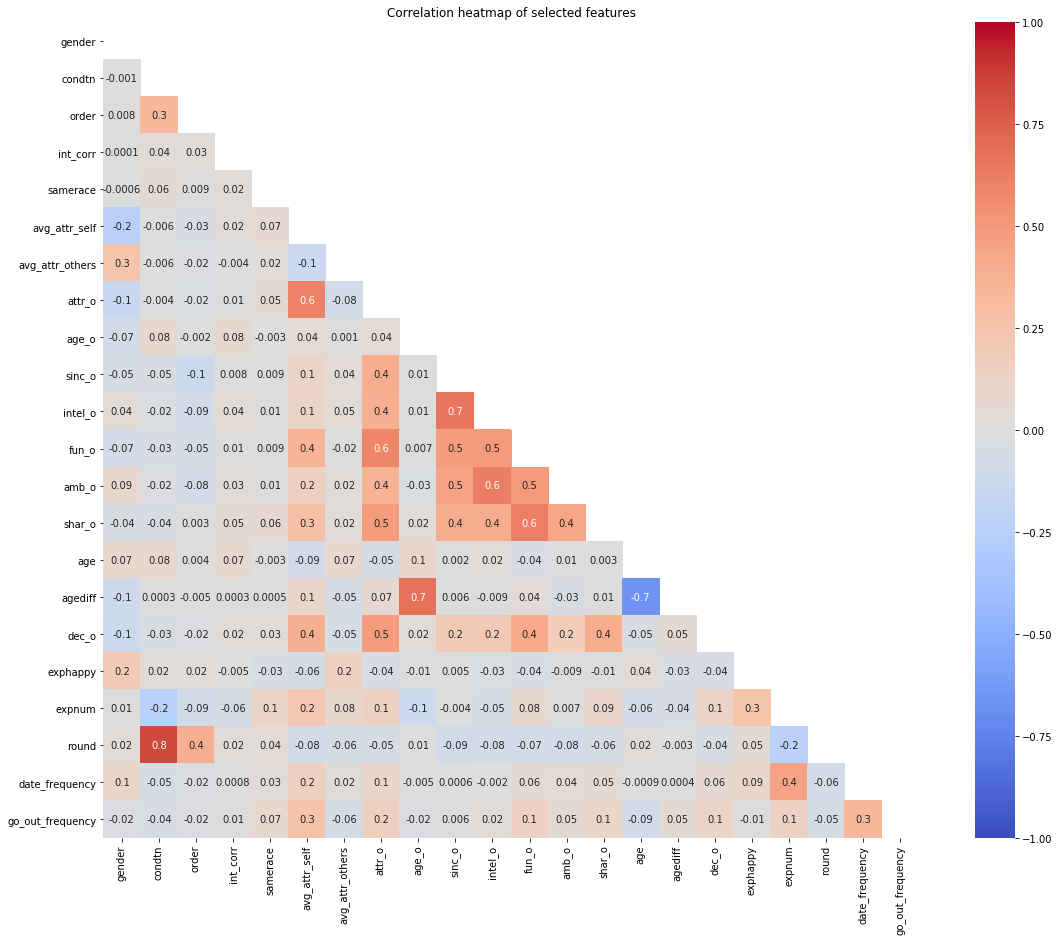

In [22]:
#make correlation heatmap

plt.subplots(figsize=(20,15))
plt.title('Correlation heatmap of selected features')

matrix = np.triu(data[['gender', 'condtn', 'order', 'int_corr', 'samerace', 'avg_attr_self', 
            'avg_attr_others', 'attr_o', 'age_o', 'sinc_o', 'intel_o',
           'fun_o', 'amb_o', 'shar_o', 'age', 'agediff','dec_o','exphappy',
                       'expnum','round','date_frequency','go_out_frequency']].corr())


sns.heatmap(data[['gender', 'condtn', 'order', 'int_corr', 'samerace', 'avg_attr_self', 
            'avg_attr_others', 'attr_o', 'age_o', 'sinc_o', 'intel_o',
           'fun_o', 'amb_o', 'shar_o', 'age', 'agediff','dec_o','exphappy','expnum',
                  'round','date_frequency','go_out_frequency']].corr(), mask = matrix,annot=True,
            square = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g')

In [6]:
#set features for algorithms

features = ['gender', 'round', 'order', 'int_corr', 'samerace', 'avg_attr_self', 
            'avg_attr_others', 'attr_o', 'age_o', 'sinc_o', 'intel_o',
           'fun_o', 'amb_o', 'shar_o', 'age', 'agediff','date_frequency','go_out_frequency']

target = ['dec_o']

In [7]:
#here we see which features still have null columns and how many of them are actually null


print('Columns with Missing values: ')
data[features].isna().any()[lambda x: x]

Columns with Missing values: 


int_corr            True
age_o               True
sinc_o              True
intel_o             True
fun_o               True
amb_o               True
shar_o              True
age                 True
agediff             True
date_frequency      True
go_out_frequency    True
dtype: bool

In [8]:
#checks how many features are missing for each column

print(data.int_corr.isnull().sum())
print(data.age_o.isnull().sum())
print(data.sinc_o.isnull().sum())
print(data.intel_o.isnull().sum())
print(data.fun_o.isnull().sum())
print(data.amb_o.isnull().sum())
print(data.fun_o.isnull().sum())
print(data.amb_o.isnull().sum())
print(data.shar_o.isnull().sum())
print(data.age.isnull().sum())
print(data.agediff.isnull().sum())
print(data.exphappy.isnull().sum())
print(data.expnum.isnull().sum())
print(data.go_out_frequency.isnull().sum())
print(data.date_frequency.isnull().sum())

143
83
83
93
151
501
151
501
833
82
165
89
6005
72
90


In [9]:
#drop necissary null columns and make an initial test/train split for ebm

data = data[['gender', 'condtn', 'order', 'int_corr', 'samerace', 'avg_attr_self', 
            'avg_attr_others', 'dec_o', 'attr_o', 'age_o', 'sinc_o', 'intel_o',
           'fun_o', 'amb_o', 'shar_o', 'age', 'agediff','round','date_frequency','go_out_frequency']].dropna()


# how balenced is the data?

matched = data.loc[data['dec_o'] == 1]

print(len(data))
print(matched.shape)


X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

6495
(2832, 20)


In [10]:
#explore feature distributions

hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')
show(hist)

<!-- http://127.0.0.1:7788/140422221713168/ -->

In [11]:
# fit and launch tool to explain model

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7788/140422266803216/ -->

In [12]:
#train misclass rate
y_pred = ebm.predict(X_train)

y_train_list = y_train.values

total_num = len(y_pred)

num_wrong = 0
num_right = 0
for i in range(len(y_pred)):
    y1 = y_pred[i]
    y2 = y_train_list[i]
    if y1 != y2:
        num_wrong += 1
    if y1 == y2:
        num_right += 1
        
misclass_rate = num_wrong / total_num
print(misclass_rate)

0.22363356428021555


In [13]:
#test misclass rate
y_pred = ebm.predict(X_test)

y_test_list = y_test.values

total_num = len(y_pred)

num_wrong = 0
num_right = 0
for i in range(len(y_pred)):
    y1 = y_pred[i]
    y2 = y_test_list[i]
    if y1 != y2:
        num_wrong += 1
    if y1 == y2:
        num_right += 1
        
misclass_rate = num_wrong / total_num
print(misclass_rate)

0.2471131639722864


In [14]:
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7788/140422230980496/ -->

In [15]:
#Here we perform a 5-fold cross validation on the 4 main models.


kf = KFold(n_splits=5, shuffle=True)

ebm_train = []
ebm_test = []

lr_train = []
lr_test = []

sv_train = []
sv_test = []

tree_train = []
tree_test = []

rf_train = []
rf_test = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
    
    ebm = ExplainableBoostingClassifier()
    ebm.fit(X_train, y_train)
    ebm_train.append(ebm.score(X_train,y_train))
    ebm_test.append(ebm.score(X_test,y_test))

    lr = LogisticRegression(feature_names=features, penalty='l2', solver='liblinear', C = 1)
    lr.fit(X_train, y_train)
    lr_train.append(lr.score(X_train,y_train))
    lr_test.append(lr.score(X_test,y_test))
    
    sv = svm.SVC()
    sv.fit(X, y)
    sv_train.append(sv.score(X_train,y_train))
    sv_test.append(sv.score(X_test,y_test))

    tree = ClassificationTree()
    tree.fit(X_train, y_train)
    tree_train.append(tree.score(X_train,y_train))
    tree_test.append(tree.score(X_test,y_test))
    
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_train.append(rf.score(X_train,y_train))
    rf_test.append(rf.score(X_test,y_test))

print('ebm results: ')
print('train: '+ str(1-mean(ebm_train)))
print('test: '+ str(1-mean(ebm_test)))
print('')
print('logistic results: ')
print('train: '+ str(1-mean(lr_train)))
print('test: ' + str(1-mean(lr_test)))
print('')
print('svm results: ')
print('train: '+ str(1-mean(sv_train)))
print('test: ' + str(1-mean(sv_test)))
print('')
print('classification tree: ')
print('train: ' + str(1-mean(tree_train)))
print('test: ' + str(1-mean(tree_test)))
print('')
print('Random Forrest')
print('train: '+ str(1-mean(rf_train)))
print('test: '+ str(1-mean(rf_test)))

/Users/calebberman/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/calebberman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/calebberman/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/calebberman/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Use

ebm results: 
train: 0.22544264819091608
test: 0.24557351809083916

logistic results: 
train: 0.24707467282525009
test: 0.24819091608929944

svm results: 
train: 0.23972286374133944
test: 0.23972286374133955

classification tree: 
train: 0.2561200923787529
test: 0.25989222478829865

Random Forrest
train: 3.84911470362459e-05
test: 0.23741339491916857


In [16]:
lr_perf = ROC(lr.predict_proba).explain_perf(X_test, y_test, name='Logistic Regression')
tree_perf = ROC(tree.predict_proba).explain_perf(X_test, y_test, name='Classification Tree')

show(lr_perf)
show(tree_perf)
show(ebm_perf)

<!-- http://127.0.0.1:7788/140422260148944/ -->

<!-- http://127.0.0.1:7788/140422260150224/ -->

<!-- http://127.0.0.1:7788/140422230980496/ -->

In [17]:
blackbox_perf = ROC(blackbox_model.predict_proba).explain_perf(X_test, y_test, name='Blackbox')
show(blackbox_perf)

NameError: name 'blackbox_model' is not defined

In [ ]:
pdp = PartialDependence(predict_fn=blackbox_model.predict_proba, data=X_train)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

In [ ]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)